In [51]:
import geopandas as gpd

mainLink='https://github.com/DACSS-CSSmeths/Spatial-Exploring/raw/refs/heads/main/maps/countriesCIA.gpkg'
mapsLink=(mainLink,'maps/countriesCIA.gpkg')


gpd.list_layers(mainLink)

cia=gpd.read_file(mainLink, layer='cia')

In [53]:
import mapclassify 

In [55]:
import numpy as np

np.random.seed(12345) 

K=5
theVar=cia.obesityAdults_rate


# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts                                
q5=mapclassify.Quantiles(theVar,k=K)
# based on similarity, good for multimodal data 
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K) 

###### based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed

In [57]:
import pandas as pd

class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']

In [59]:
import matplotlib.pyplot as plt

In [61]:
cia['obesity_code']=fj5.yb

cia=cia.assign(obesity_levels=cia.obesity_code)

In [63]:
newLevels={0:'1.very low',1:'2.low', 2:'3.average',3:'4.high', 4:'5.very high'}

cia.replace({'obesity_levels':newLevels}, inplace=True)

cia.obesity_levels.value_counts()

obesity_levels
2.low          50
1.very low     44
3.average      38
4.high         11
5.very high     4
Name: count, dtype: int64

In [65]:
countries=gpd.read_file(mainLink, layer='border')
worldBorders=countries.dissolve()

In [66]:
topcountries=cia[(cia.tobacco_code==0) & (cia.alcohol_code==0) & (cia.obesity_code==0)]
topcountries

COUNTRY        name  region  obesityAdults_rate  TobaccoUse_perc  \
17        Benin       Benin  Africa                 9.6              6.9   
26         Chad        Chad  Africa                 6.1              8.3   
42      Eritrea     Eritrea  Africa                 5.0              7.5   
44     Ethiopia    Ethiopia  Africa                 4.5              5.1   
49        Ghana       Ghana  Africa                10.9              3.5   
83         Mali        Mali  Africa                 8.6              8.3   
86   Mauritania  Mauritania  Africa                12.7             10.7   
94        Niger       Niger  Africa                 5.5              7.4   
118     Senegal     Senegal  Africa                 8.8              6.9   
128        Togo        Togo  Africa                 8.4              6.8   

     Alcohol_LitersPerCap  tobacco_code tobacco_levels tobacco_custom  \
17                   1.25             0     1.very low       2.(5-15]   
26                   0.55             0     1.very low       2.(5-15]   
42                   0.93             0     1.very low       2.(5-15]   
44                   1.16             0     1.very low       2.(5-15]   
49                   1.59             0     1.very low      1. below5   
83                   0.60             0     1.very low       2.(5-15]   
86                   0.00             0     1.very low       2.(5-15]   
94                   0.11             0     1.very low       2.(5-15]   
118                  0.25             0     1.very low       2.(5-15]   
128                  1.40             0     1.very low       2.(5-15]   

     alcohol_code alcohol_levels  \
17              0     1.very low   
26              0     1.very low   
42              0     1.very low   
44              0     1.very low   
49              0     1.very low   
83              0     1.very low   
86              0     1.very low   
94              0     1.very low   
118             0     1.very low   
128             0     1.very low   

                                              geometry  obesity_code  \
17   MULTIPOLYGON (((2.733 7.6582, 2.7322 7.6519, 2...             0   
26   MULTIPOLYGON (((14.195 9.9818, 14.451 9.9981, ...             0   
42   MULTIPOLYGON (((42.068 13.698, 42.09 13.678, 4...             0   
44   MULTIPOLYGON (((45.489 5.4898, 45.374 5.3639, ...             0   
49   MULTIPOLYGON (((0.32238 6.0358, 0.35375 6.0233...             0   
83   MULTIPOLYGON (((-9.8652 12.055, -9.9119 12.093...             0   
86   MULTIPOLYGON (((-6.336 22.99, -6.3258 22.906, ...             0   
94   MULTIPOLYGON (((7.0281 12.996, 6.9422 12.997, ...             0   
118  MULTIPOLYGON (((-14.342 12.679, -14.393 12.679...             0   
128  MULTIPOLYGON (((1.6554 7.5298, 1.6501 7.5139, ...             0   

    obesity_levels  
17      1.very low  
26      1.very low  
42      1.very low  
44      1.very low  
49      1.very low  
83      1.very low  
86      1.very low  
94      1.very low  
118     1.very low  
128     1.very low

In [67]:
maskToClip=topcountries.dissolve().envelope

In [71]:
miniWorld=worldBorders.clip(maskToClip)

In [73]:
allCoords=[x.coords[:][0] for x in topcountries.representative_point()]
allCoords
topcountries=topcountries.assign(coordinates=allCoords)

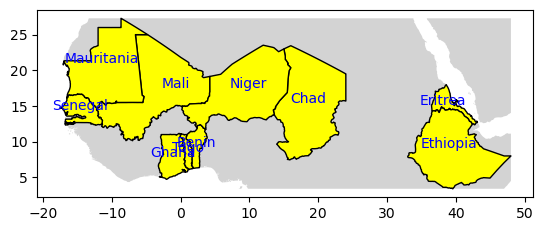

In [75]:
base=miniWorld.plot(color='lightgrey')
topcountries.plot(color='yellow', edgecolor='black',ax=base)
for idx, row in topcountries.iterrows():
   plt.annotate(text=row['name'], xy=row['coordinates'], horizontalalignment='center', color='blue')